In [23]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')


#### Importing the CSV Data as Pandas DataFrame

In [24]:
df = pd.read_csv('data\Online_fraud.csv')

#### Show Top 5 Records

In [25]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [26]:
# List of columns to drop (adjust as needed)
columns_to_drop = ['nameOrig', 'nameDest']  

# Drop the columns
df = df.drop(columns=columns_to_drop, axis=1)

print("Remaining Columns:")
print(df.columns)

Remaining Columns:
Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')


#### Preparing X and Y variables

In [27]:
X = df.drop(columns=['isFraud'],axis=1)

In [28]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [29]:
y = df['isFraud']

In [30]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

In [31]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [32]:
X = preprocessor.fit_transform(X)

In [33]:
X.shape

(567, 12)

In [34]:
# Separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((453, 12), (114, 12))

#### Creating an Evaluate Function to give all metrics after model Training

In [35]:
def evaluate_classification_model(true, predicted, predicted_probs=None):

    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, average='binary')
    recall = recall_score(true, predicted, average='binary')
    f1 = f1_score(true, predicted, average='binary')

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }

    # Include ROC AUC score if probabilities are provided
    if predicted_probs is not None:
        auc = roc_auc_score(true, predicted_probs)
        metrics["ROC AUC"] = auc

    return metrics

In [36]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Support Vector Classifier": SVC(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier()
}

model_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred, average='weighted')
    model_train_recall = recall_score(y_train, y_train_pred, average='weighted')
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred, average='weighted')
    model_test_recall = recall_score(y_test, y_test_pred, average='weighted')
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print('----------------------------------')

    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    
    accuracy_list.append(model_test_accuracy)
    precision_list.append(model_test_precision)
    recall_list.append(model_test_recall)
    f1_list.append(model_test_f1)

    print('='*35)
    print('\n')

Logistic Regression
Model performance for Training set
- Accuracy: 0.9934
- Precision: 0.9868
- Recall: 0.9934
- F1 Score: 0.9901
----------------------------------
Model performance for Test set
- Accuracy: 0.9912
- Precision: 0.9825
- Recall: 0.9912
- F1 Score: 0.9869


Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000


AdaBoost Classifier
Model performance for Training set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000


Support Vector Classifier
Model performance for Training set
- Accuracy: 0.9934
- Precision: 0.9868
- Recall: 0.9934
- F1 Score: 0.9901
----------------------------------
Model

In [37]:
metrics_df = pd.DataFrame(list(zip(model_list, accuracy_list, precision_list, recall_list, f1_list)), 
                          columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Sorting the DataFrame by accuracy (or any other metric)
metrics_df_sorted = metrics_df.sort_values(by=["Accuracy"], ascending=False)

# Displaying the sorted DataFrame
print(metrics_df_sorted)

                  Model Name  Accuracy  Precision    Recall  F1 Score
1   Random Forest Classifier  1.000000   1.000000  1.000000  1.000000
2        AdaBoost Classifier  1.000000   1.000000  1.000000  1.000000
5   Decision Tree Classifier  1.000000   1.000000  1.000000  1.000000
0        Logistic Regression  0.991228   0.982533  0.991228  0.986861
3  Support Vector Classifier  0.991228   0.982533  0.991228  0.986861
4     K-Neighbors Classifier  0.991228   0.982533  0.991228  0.986861


#### Grouped Bar Plot

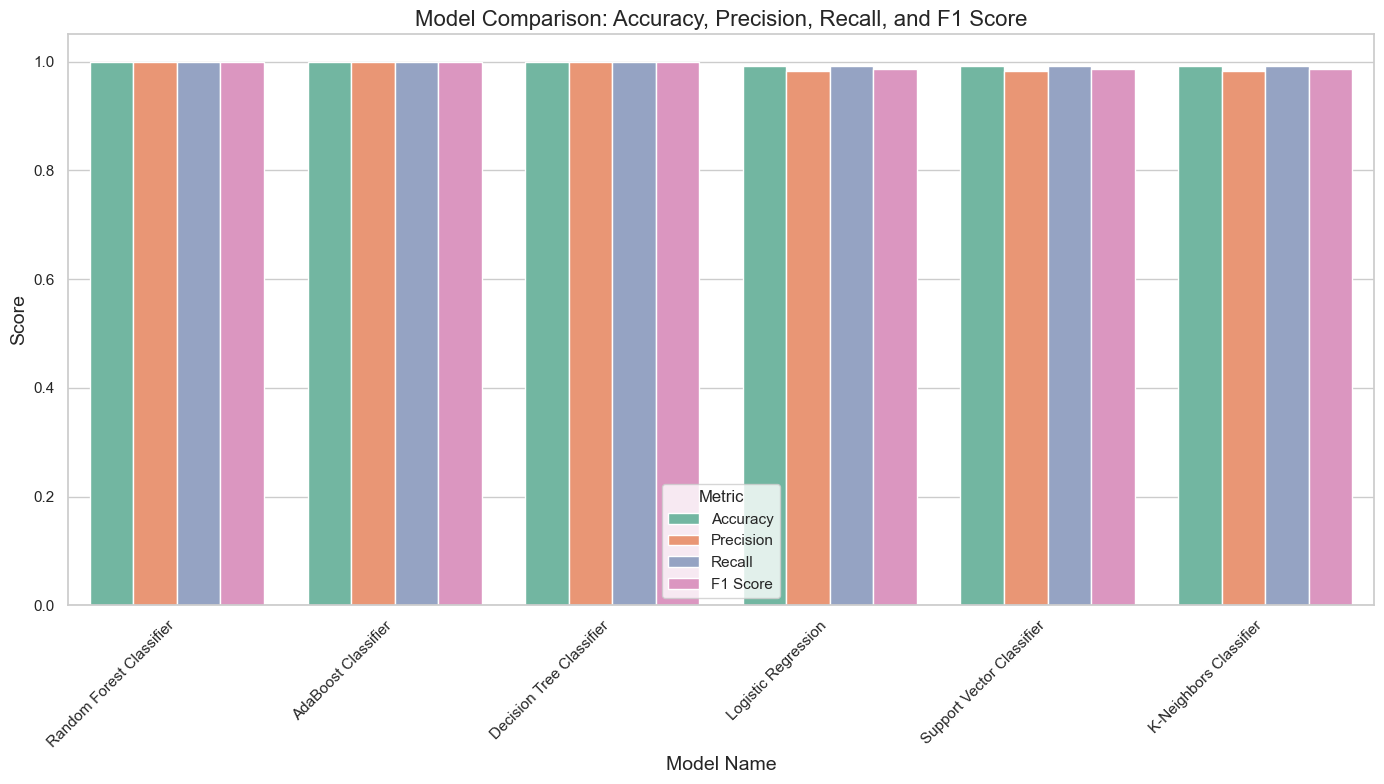

In [38]:
# Melt the metrics DataFrame for easy plotting with seaborn
metrics_melted = metrics_df_sorted.melt(id_vars="Model Name", 
                                        value_vars=["Accuracy", "Precision", "Recall", "F1 Score"], 
                                        var_name="Metric", 
                                        value_name="Score")

# Set the style for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 8))

# Plot the grouped bar plot
sns.barplot(x="Model Name", y="Score", hue="Metric", data=metrics_melted, palette="Set2")

# Adding titles and labels
plt.title("Model Comparison: Accuracy, Precision, Recall, and F1 Score", fontsize=16)
plt.xlabel("Model Name", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()